# Target Encoder

Categorical variables are a challenge for Machine Learning algorithms. Since most (if not all) of them accept only numerical values as inputs, we need to transform the categories into numbers to use them in the model.

By one-hot encoding them, we create a really sparse matrix and inflate the number of dimensions the model needs to work with, and we may fall victim to the dreaded Curse of Dimensionality. This is amplified when the feature has too many categories, most of them being useless for the prediction.

One clever approach to deal with this problem is the Target Encoder.

The code and examples used on this article are also available on my GitHub repository:

### Imports

In [49]:
import pandas as pd
import numpy as np

Target Encoder
The main idea behind the target encoder is to encode the categories by replacing them for a measurement of the effect they might have on the target.

On a binary classifier, the simplest way to do that is by calculating the probability p(t = 1 | x = ci) in which t denotes the target, x is the input and ci is the i-th category. In Bayesian statistics, this is considered the posterior probability of t=1 given the input was the category ci.

This means we will replace the category ci for the value of the posterior probability of the target being 1 on the presence of that category.

### Synthetic Dataset

In [48]:
seed = 321

In [50]:
np.random.seed(seed)
target = list(np.random.randint(0, 2, 20))

In [51]:
genre = ["Sci Fi", "Drama", "Romance", "Fantasy", "Nonfiction"]

In [52]:
np.random.seed(seed)
genres = [genre[i] for i in np.random.randint(0, len(genre), 20)]

In [53]:
df = pd.DataFrame({"genre" : genres, "target" : target})

In [54]:
df

,genre,target
0,Nonfiction,0
1,Romance,0
2,Nonfiction,0
3,Drama,1
4,Sci Fi,1
5,Drama,0
6,Sci Fi,1
7,Romance,0
8,Sci Fi,0
9,Nonfiction,0


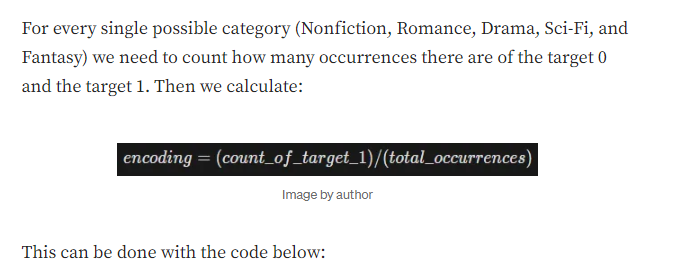

### Using Probabilities
Calculating only the posteriors, by calculating the conditional probability

In [55]:
categories = df['genre'].unique()
targets = df['target'].unique()
cat_list = []
for cat in categories:
    aux_dict = {}
    aux_dict['category'] = cat
    aux_df = df[df['genre'] == cat]
    counts = aux_df['target'].value_counts()
    aux_dict['count'] = sum(counts)
    for t in targets:
        aux_dict['target_' + str(t)] = counts[t]
    cat_list.append(aux_dict)

In [56]:
cat_list = pd.DataFrame(cat_list)

In [57]:
cat_list


,category,count,target_0,target_1
0,Nonfiction,4,3,1
1,Romance,5,4,1
2,Drama,3,1,2
3,Sci Fi,4,2,2
4,Fantasy,4,1,3


In [58]:
cat_list['genre_encoded_prob'] = cat_list['target_1'] / cat_list['count']

In [59]:
cat_list

,category,count,target_0,target_1,genre_encoded_prob
0,Nonfiction,4,3,1,0.250000
1,Romance,5,4,1,0.200000
2,Drama,3,1,2,0.666667
3,Sci Fi,4,2,2,0.500000
4,Fantasy,4,1,3,0.750000


In [60]:
df = df.join(cat_list.drop(columns = ['count', 'target_1', 'target_0']).set_index('category'), on = 'genre', how = 'left')
df

,genre,target,genre_encoded_prob
0,Nonfiction,0,0.250000
1,Romance,0,0.200000
2,Nonfiction,0,0.250000
3,Drama,1,0.666667
4,Sci Fi,1,0.500000
5,Drama,0,0.666667
6,Sci Fi,1,0.500000
7,Romance,0,0.200000
8,Sci Fi,0,0.500000
9,Nonfiction,0,0.250000


### Using the mean
Calculating only the posteriors

Since the target of interest is the value “1”, this probability is actually the mean of the target, given a category. This is the reason why this method of target encoding is also called “mean” encoding.

We can calulate this mean with a simple aggregation, then:

In [61]:
stats = df['target'].groupby(df['genre']).agg(['count', 'mean'])
stats

,count,mean
genre,,
Drama,3,0.666667
Fantasy,4,0.750000
Nonfiction,4,0.250000
Romance,5,0.200000
Sci Fi,4,0.500000


In [30]:
df = df.join(stats.drop(columns = 'count'), on = 'genre', how = 'left').rename(columns = {'mean'  : 'genre_encoded_mean'})
df

,genre,target,genre_encoded_prob,genre_encoded_mean
0,Nonfiction,0,0.250000,0.250000
1,Romance,0,0.200000,0.200000
2,Nonfiction,0,0.250000,0.250000
3,Drama,1,0.666667,0.666667
4,Sci Fi,1,0.500000,0.500000
5,Drama,0,0.666667,0.666667
6,Sci Fi,1,0.500000,0.500000
7,Romance,0,0.200000,0.200000
8,Sci Fi,0,0.500000,0.500000
9,Nonfiction,0,0.250000,0.250000


### With Smoothing
sklearn method uses some smoothing based on the prior

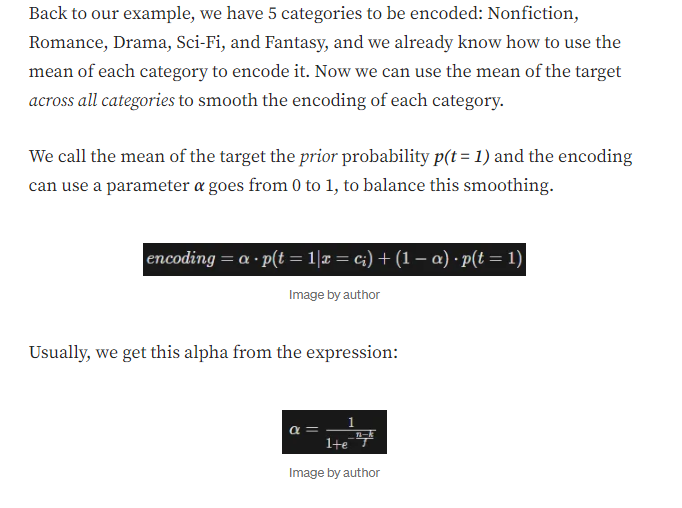

In [31]:
smoothing_factor = 1.0
min_samples_leaf = 1

In [32]:
prior = df['target'].mean()

In [33]:
smoove = 1 / (1 + np.exp(-(stats['count'] - min_samples_leaf) / smoothing_factor))

In [34]:
smoothing = prior * (1 - smoove) + stats['mean'] * smoove

In [35]:
encoded = pd.Series(smoothing, name = 'genre_encoded_smoothing')
encoded

genre
Drama         0.640839
Fantasy       0.735772
Nonfiction    0.259485
Romance       0.204497
Sci Fi        0.497629
Name: genre_encoded_smoothing, dtype: float64

In [36]:
df = df.join(encoded, on = 'genre', how = 'left')
df

,genre,target,genre_encoded_prob,genre_encoded_mean,genre_encoded_smoothing
0,Nonfiction,0,0.250000,0.250000,0.259485
1,Romance,0,0.200000,0.200000,0.204497
2,Nonfiction,0,0.250000,0.250000,0.259485
3,Drama,1,0.666667,0.666667,0.640839
4,Sci Fi,1,0.500000,0.500000,0.497629
5,Drama,0,0.666667,0.666667,0.640839
6,Sci Fi,1,0.500000,0.500000,0.497629
7,Romance,0,0.200000,0.200000,0.204497
8,Sci Fi,0,0.500000,0.500000,0.497629
9,Nonfiction,0,0.250000,0.250000,0.259485


This encoding method is really easy and powerful. However, there are important issues that you need to keep in mind when using that.

One really important effect is the Target Leakage. By using the probability of the target to encode the features we are feeding them with information of the very variable we are trying to model. This is like “cheating” since the model will learn from a variable that contains the target in itself.



### Sklearn category_encoders

https://contrib.scikit-learn.org/category_encoders/targetencoder.html

In [64]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.4 MB/s eta 0:00:00


In [65]:
from category_encoders import TargetEncoder

In [66]:
encoder = TargetEncoder()

In [67]:
df['genre_encoded_sklearn'] = encoder.fit_transform(df['genre'], df['target'])

In [68]:
df

,genre,target,genre_encoded_prob,genre_encoded_sklearn
0,Nonfiction,0,0.250000,0.416404
1,Romance,0,0.200000,0.404394
2,Nonfiction,0,0.250000,0.416404
3,Drama,1,0.666667,0.483467
4,Sci Fi,1,0.500000,0.458399
5,Drama,0,0.666667,0.483467
6,Sci Fi,1,0.500000,0.458399
7,Romance,0,0.200000,0.404394
8,Sci Fi,0,0.500000,0.458399
9,Nonfiction,0,0.250000,0.416404
